## 데이터 다운로드

In [3]:
import pandas as pd
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb

In [4]:

import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import MinMaxScaler

In [5]:
import numpy as np

In [6]:
!wget 'https://bit.ly/3dD5MU9'

import zipfile
with zipfile.ZipFile('3dD5MU9', 'r') as existing_zip:
    existing_zip.extractall('data')

--2021-06-01 14:13:20--  https://bit.ly/3dD5MU9
Resolving bit.ly (bit.ly)... 67.199.248.10, 67.199.248.11
Connecting to bit.ly (bit.ly)|67.199.248.10|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://drive.google.com/uc?export=download&id=1kkF00wW8v0npJ8S2nA7--eMTH3gOL03z [following]
--2021-06-01 14:13:20--  https://drive.google.com/uc?export=download&id=1kkF00wW8v0npJ8S2nA7--eMTH3gOL03z
Resolving drive.google.com (drive.google.com)... 172.217.203.138, 172.217.203.113, 172.217.203.100, ...
Connecting to drive.google.com (drive.google.com)|172.217.203.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-14-94-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/7u5aqvukr0d9aiiehbkbfcfal8lj4skb/1622556750000/00192245294648390361/*/1kkF00wW8v0npJ8S2nA7--eMTH3gOL03z?e=download [following]
--2021-06-01 14:13:28--  https://doc-14-94-docs.googleusercontent.com/docs/secur

In [7]:
import pandas as pd
energy = pd.read_csv('data/energy.csv')
dangjin_fcst = pd.read_csv('./data/dangjin_fcst_data.csv')
ulsan_fcst = pd.read_csv('./data/ulsan_fcst_data.csv')
pd.read_csv('data/dangjin_fcst_data.csv')

,Forecast time,forecast,Temperature,Humidity,WindSpeed,WindDirection,Cloud
0,2018-03-01 11:00:00,4.0,0.0,60.0,7.3,309.0,2.0
1,2018-03-01 11:00:00,7.0,-2.0,60.0,7.1,314.0,1.0
2,2018-03-01 11:00:00,10.0,-2.0,60.0,6.7,323.0,1.0
3,2018-03-01 11:00:00,13.0,-2.0,55.0,6.7,336.0,1.0
4,2018-03-01 11:00:00,16.0,-4.0,55.0,5.5,339.0,1.0
...,...,...,...,...,...,...,...
162203,2021-03-01 08:00:00,52.0,7.0,40.0,3.2,187.0,1.0
162204,2021-03-01 08:00:00,55.0,8.0,40.0,4.5,217.0,1.0
162205,2021-03-01 08:00:00,58.0,5.0,55.0,2.2,210.0,1.0
162206,2021-03-01 08:00:00,61.0,1.0,80.0,1.9,164.0,1.0


## 데이터 병합

In [8]:
def to_date(x):
    return timedelta(hours=x)

In [9]:
def generate_df(df_):
    df = df_.copy()

    df['Forecast_time'] = pd.to_datetime(df['Forecast time'])

    # 20 시
    a = df[df["forecast"] == 4.0]
    a = a[a["Forecast time"].apply(lambda x: "20:00:00" in x)]
    a.loc[:, 'Forecast_time'] = a.loc[:, 'Forecast_time'] + a.loc[:, 'forecast'].map(to_date)

    # 23 시
    b = df[df["forecast"] <= 22]
    b = b[b["Forecast time"].apply(lambda x: "23:00:00" in x)]
    b.loc[:, 'Forecast_time'] = b.loc[:, 'Forecast_time'] + b.loc[:, 'forecast'].map(to_date)

    # 병합
    c = pd.concat([a, b])
    print(f"20시 사용 데이터 길이 : {len(a)}")
    print(f"23시 사용 데이터 길이 : {len(b)}")
    print(f"합친 데이터 길이 : {len(c)}")
    print()

    # 정렬
    c.sort_values(by=['Forecast_time'], inplace=True)
    c = c[['Forecast_time', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud']]

    return c

In [10]:
dangjin_filled = generate_df(dangjin_fcst)
ulsan_filled = generate_df(ulsan_fcst)

20시 사용 데이터 길이 : 1096
23시 사용 데이터 길이 : 7672
합친 데이터 길이 : 8768

20시 사용 데이터 길이 : 1096
23시 사용 데이터 길이 : 7672
합친 데이터 길이 : 8768



## 보간

In [11]:
def interpolate_df(df, method='linear'):
    new_df = pd.DataFrame()
    new_df['Forecast_time'] = pd.date_range(start=df['Forecast_time'].iloc[0], end=df['Forecast_time'].iloc[-1], freq='H')
    new_df = pd.merge(new_df, df, on='Forecast_time', how='outer')
    return new_df.interpolate(method=method)

In [12]:
dangjin_interpolated = interpolate_df(dangjin_filled, method='linear')
ulsan_interpolated = interpolate_df(ulsan_filled, method='linear')

In [18]:
def train_datast(energy_df, fcst_df, target):
    # 일기 예보 있는 날짜만 선택
    energy = energy_df.loc[24:]
    energy.index = range(energy.shape[0])
    
    # 발전량 데이터가 있는 날짜만 선택
    fcst = fcst_df
    fcst.index = range(fcst.shape[0])
    
    # 발전량과 일기예보 연결
    concat_df = pd.concat([energy, fcst], axis=1)
    
    
    # 예보 시간, 날짜, 기상 예보 및 발전량 선택
    feature_df = concat_df[['Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud', target]]
    feature_df.fillna(0,inplace = True)

    return np.array(feature_df[:-22])


In [19]:
dangjin_interpolated['Forecast_time'] = dangjin_interpolated['Forecast_time'].astype('str')
ulsan_interpolated['Forecast_time'] = ulsan_interpolated['Forecast_time'].astype('str')

In [20]:
df = train_datast(energy, dangjin_interpolated, target='dangjin_floating')

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [21]:
df

array([[ -2.        ,  50.        ,   5.8       , 336.        ,
          1.        ,   0.        ],
       [ -2.33333333,  51.66666667,   5.53333333, 337.        ,
          1.        ,   0.        ],
       [ -2.66666667,  53.33333333,   5.26666667, 338.        ,
          1.        ,   0.        ],
       ...,
       [  7.        ,  70.        ,   1.3       ,  18.        ,
          4.        ,   0.        ],
       [  6.66666667,  68.33333333,   1.3       ,  27.        ,
          4.        ,   0.        ],
       [  6.33333333,  66.66666667,   1.3       ,  36.        ,
          4.        ,   0.        ]])

## 하이퍼 파라미터 


In [22]:
# hyper parameters
seq_length = 24 # 입력 시퀀스 길이
data_dim = 6 # 입력 데이터 차원 (변수 갯수)
hidden_dim = 30 #(출력 데이터의 차원)
output_dim = 1 #(최종 예측 데이터 차원)
learning_rate = 0.01
iterations = 3000

In [23]:


train_size = int(len(df) * 1)
train_set = df[:train_size]
test_set = df[train_size-672:]
train_set.shape, test_set.shape

((26280, 6), (672, 6))

In [ ]:
len(df)

26280

## MinMax 정규화


In [ ]:
'''scaler = MinMaxScaler()
scaler.fit(train_set)
train_set = scaler.transform(train_set)
test_set = scaler.transform(test_set)'''

'scaler = MinMaxScaler()\nscaler.fit(train_set)\ntrain_set = scaler.transform(train_set)\ntest_set = scaler.transform(test_set)'

In [24]:
def make_sequence(time_series, seq_length):
    dataX = []
    dataY = []

    for i in range(0, len(time_series) - seq_length) :
        _x = time_series[i:i + seq_length, : ] 
        _y = time_series[i+ seq_length, [-1]]
        

        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)

In [25]:
class Net(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, layers):
        super(Net, self).__init__()
        self.rnn = torch.nn.LSTM(input_dim, hidden_dim, num_layers=layers, batch_first=True, bidirectional=True)
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim*2, 20),
            torch.nn.Linear(20, 10),
            torch.nn.Linear(10, output_dim)
        )
    def forward(self, x):
        x, (hidden, cell) = self.rnn(x)
        x = self.layers(x[:, -1, ])
        return x
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
net = Net(data_dim, hidden_dim, output_dim, 4).to(device)

In [26]:
# train-test dataset to input

trainX, trainY = make_sequence(train_set, seq_length)
testX, testY = make_sequence(test_set, seq_length)

# convert to tensor
trainX_tensor = torch.FloatTensor(trainX).to(device)
trainY_tensor = torch.FloatTensor(trainY).to(device)

testX_tensor = torch.FloatTensor(testX).to(device)
testY_tensor = torch.FloatTensor(testY).to(device)

In [27]:
# loss & optimizer setting
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
# start training
net.train()
for i in range(1):
    outputs = net(trainX_tensor)
    loss = criterion(outputs, trainY_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if i%100 == 0:
        print('Epoch {}, Loss {:.5f}'.format(i, loss.item()))

Epoch 0, Loss 50339.82031


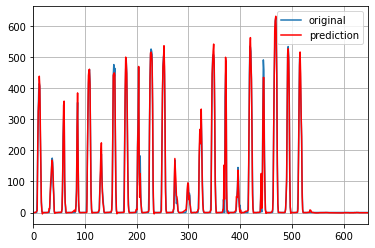

In [ ]:
net.eval()
predict_data = net(testX_tensor ).cpu().detach().numpy()
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(testY)
plt.plot(predict_data, color='red')
plt.legend(['original', 'prediction'])
plt.show()

In [ ]:
predict_data = net(testX_tensor ).cpu().detach().numpy()

In [ ]:
x_input = np.array(testX_tensor[:25].cpu().detach()) #  next value based on data of last year
#x_input
#x_input = x_input.reshape((1, 24, 1)) 
#dangjin_floating_pred = []


In [ ]:
x_input = torch.Tensor(x_input)
x_input = x_input.to(device)
predict = net(x_input).cpu().detach().numpy()

In [ ]:
len(predict)

25

In [ ]:
x_input = np.array(testX_tensor[:24].cpu().detach())

In [29]:
len(testX_tensor[0][0])

6

In [ ]:
for i in range(672):
    
    x_input = torch.Tensor(x_input)
    x_input = x_input.to(device)
    predict = dangjin_floating(x_input).cpu().detach().numpy()
    
    new_input = predict.reshape((1,1,1))
    x_input = np.concatenate((x_input[:,-23:].cpu(), new_input), axis = 1)
    dangjin_floating_pred.append(predict[0][0])

NameError: name 'x_input' is not defined